In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy.optimize import brentq
from datetime import datetime

In [2]:
# URL de la página a hacer scraping
url = 'https://www.meff.es/esp/Derivados-Financieros/Ficha/FIEM_MiniIbex_35'

# Realizar la petición HTTP GET a la página
response = requests.get(url)

# Crear un dataframe vacío en caso de error en la petición
df_opciones = pd.DataFrame()
df_futuros = pd.DataFrame()

# Comprobar si la petición fue exitosa
if response.status_code == 200:
    soup = BeautifulSoup(response.content, 'html.parser')
    
    # Scraping de opciones
    table_opciones = soup.find('table', id='tblOpciones')
    all_rows_data = []
    if table_opciones:
        rows = table_opciones.find_all('tr', class_='text-right')
        for row in rows:
            cells = row.find_all('td')
            row_data = [cell.text.strip() for cell in cells]
            data_tipo = row.get('data-tipo', 'No especificado')
            row_data.insert(0, data_tipo)
            all_rows_data.append(row_data)
        
        # Definir los nombres de las columnas
        titulo_columna = ['Class', 'Strike', 'Buy_ord', 'Buy_vol', 'Buy_price', 'Sell_price', 'Sell_vol', 'Sell_ord', 'Ult', 'Vol', 'Aper', 'Max.', 'Min.', 'Ant']
        df_opciones = pd.DataFrame(all_rows_data, columns=titulo_columna)
        
        # Limpiar y organizar las columnas
        df_opciones['Tipo'] = df_opciones['Class'].str[:3]
        df_opciones['Fecha'] = pd.to_datetime(df_opciones['Class'].str[3:], format='%Y%m%d').dt.strftime('%d-%m-%Y')
        df_opciones = df_opciones.drop(['Class'], axis=1)
        column_order = ['Tipo', 'Fecha'] + [col for col in df_opciones.columns if col not in ['Tipo', 'Fecha']]
        df_opciones = df_opciones.reindex(columns=column_order)
        
        # Convertir el formato de 'Strike' y precios a numérico
        df_opciones['Strike'] = pd.to_numeric(df_opciones['Strike'].str.replace('.', '').str.replace(',', '.'), errors='coerce')
        df_opciones['Buy_price'] = pd.to_numeric(df_opciones['Buy_price'].str.replace('.', '').str.replace(',', '.'), errors='coerce')
        df_opciones['Sell_price'] = pd.to_numeric(df_opciones['Sell_price'].str.replace('.', '').str.replace(',', '.'), errors='coerce')
        
        # Convertir la columna 'Fecha' a tipo datetime
        df_opciones['Fecha'] = pd.to_datetime(df_opciones['Fecha'], format='%d-%m-%Y')
        
        # Separar los dataframes de Calls y Puts
        calls = df_opciones[df_opciones['Tipo'] == 'OCE'][['Fecha', 'Strike', 'Buy_price', 'Sell_price']]
        puts = df_opciones[df_opciones['Tipo'] == 'OPE'][['Fecha', 'Strike', 'Buy_price', 'Sell_price']]
        
        # Renombrar columnas para Calls y Puts
        calls.rename(columns={'Buy_price': 'Call_buy_price', 'Sell_price': 'Call_sell_price'}, inplace=True)
        puts.rename(columns={'Buy_price': 'Put_buy_price', 'Sell_price': 'Put_sell_price'}, inplace=True)
        
        # Unir los dataframes por 'Strike' y 'Fecha'
        combined_df = pd.merge(calls, puts, on=['Fecha', 'Strike'], how='outer')
        
        # Ordenar por 'Fecha' y 'Strike'
        combined_df.sort_values(by=['Fecha', 'Strike'], ascending=[True, True], inplace=True)
        
        # Establecer 'Fecha' como índice
        combined_df.set_index('Fecha', inplace=True)
        
        # Calcular la columna 'T' en el DataFrame combined_df
        combined_df['T'] = (combined_df.index - pd.Timestamp(datetime.now().date())).days / 365.25
        
        # Seleccionar las columnas deseadas
        combined_df = combined_df[['Strike', 'Call_buy_price', 'Call_sell_price', 'Put_buy_price', 'Put_sell_price', 'T']]
        
        # Exportar el DataFrame limpio y organizado
        combined_df.to_csv('opciones_mini_ibex_35.csv', sep=';', decimal=',', index=True)
        
        print("Dataframe de Opciones: combined_df")

    # Scraping de futuros
    tabla_futuros = soup.find('table', {'id': 'Contenido_Contenido_tblFuturos'})
    datos_tabla = []
    if tabla_futuros:
        for fila in tabla_futuros.find_all('tr')[2:]:
            celdas = fila.find_all('td')
            fila_datos = [celda.get_text(strip=True) for celda in celdas]
            datos_tabla.append(fila_datos)

        columnas = ['Vencimiento', 'Tipo', 'Compra_Ord', 'Compra_Vol', 'Compra_Precio', 'Venta_Precio', 'Venta_Vol', 'Venta_Ord', 'Ult', 'Vol', 'Aper', 'Max', 'Min', 'Ant']
        df_futuros = pd.DataFrame(datos_tabla, columns=columnas)

        # Limpieza y conversión de tipos de datos como hemos hecho previamente
        df_futuros['Compra_Precio'] = pd.to_numeric(df_futuros['Compra_Precio'].str.replace('.', '').str.replace(',', '.'), errors='coerce')
        df_futuros['Venta_Precio'] = pd.to_numeric(df_futuros['Venta_Precio'].str.replace('.', '').str.replace(',', '.'), errors='coerce')
        df_futuros['Vencimiento'] = pd.to_datetime(df_futuros['Vencimiento'], format='%d %b %Y', errors='coerce')

        # Guardar el DataFrame de Futuros en un archivo CSV delimitado por ; y decimales con ,
        df_futuros.to_csv('futuros_mini_ibex_35.csv', sep=';', decimal=',', index=False)

        print("\nDataframe de Futuros: df_futuros")

Dataframe de Opciones: combined_df

Dataframe de Futuros: df_futuros


In [3]:
combined_df

,Strike,Call_buy_price,Call_sell_price,Put_buy_price,Put_sell_price,T
Fecha,,,,,,
2024-04-26,9000.0,2060.0,2120.0,NaN,5.0,0.005476
2024-04-26,9100.0,1960.0,2020.0,NaN,5.0,0.005476
2024-04-26,9200.0,1860.0,1920.0,NaN,5.0,0.005476
2024-04-26,9300.0,1760.0,1820.0,NaN,5.0,0.005476
2024-04-26,9400.0,1660.0,1720.0,NaN,5.0,0.005476
...,...,...,...,...,...,...
2025-06-20,13300.0,75.0,93.0,2232.0,2292.0,1.155373
2025-06-20,13400.0,66.0,84.0,2319.0,2379.0,1.155373
2025-06-20,13500.0,58.0,76.0,2408.0,2468.0,1.155373


In [4]:
combined_df

,Strike,Call_buy_price,Call_sell_price,Put_buy_price,Put_sell_price,T
Fecha,,,,,,
2024-04-26,9000.0,2060.0,2120.0,NaN,5.0,0.005476
2024-04-26,9100.0,1960.0,2020.0,NaN,5.0,0.005476
2024-04-26,9200.0,1860.0,1920.0,NaN,5.0,0.005476
2024-04-26,9300.0,1760.0,1820.0,NaN,5.0,0.005476
2024-04-26,9400.0,1660.0,1720.0,NaN,5.0,0.005476
...,...,...,...,...,...,...
2025-06-20,13300.0,75.0,93.0,2232.0,2292.0,1.155373
2025-06-20,13400.0,66.0,84.0,2319.0,2379.0,1.155373
2025-06-20,13500.0,58.0,76.0,2408.0,2468.0,1.155373


In [24]:
df = combined_df.iloc[1:7, :]

In [25]:
# Definiendo la función que realizará el cálculo
def calcular_promedio(row):
    if pd.notna(row['Put_buy_price']) and pd.notna(row['Put_sell_price']):
        return (row['Put_buy_price'] + row['Put_sell_price']) / 2
    elif pd.notna(row['Put_buy_price']):
        return row['Put_buy_price']
    else:
        return row['Put_sell_price']

In [26]:
# Aplicando la función a la fila especificada
resultado = df.apply(calcular_promedio, axis=1)

In [27]:
resultado

Fecha
2024-04-26    5.0
2024-04-26    5.0
2024-04-26    5.0
2024-04-26    5.0
2024-04-26    5.0
2024-04-26    5.0
dtype: float64

In [10]:

# Función para calcular el precio de una opción call europea usando Black-Scholes
def black_scholes_call(S, K, T, r, sigma):
    if T <= 0:  # No se puede calcular precio de una opción con tiempo hasta vencimiento negativo o cero
        return 0
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

def black_scholes_put(S, K, T, r, sigma):
    if T <= 0:  # No se puede calcular precio de una opción con tiempo hasta vencimiento negativo o cero
        return 0
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

# Función para extraer la volatilidad implícita
def implied_volatility(option_price, S, K, T, r, option_type):
    """Calcula la volatilidad implícita de una opción dada su precio de mercado.
    option_price : Precio de mercado de la opción
    S : Precio del activo subyacente
    K : Precio de ejercicio
    T : Tiempo hasta el vencimiento
    r : Tasa de interés libre de riesgo
    option_type : Tipo de opción ('call' o 'put')
    """
    if option_price <= 0 or T <= 0:
        return 0
    # Función objetivo para encontrar la volatilidad implícita
    def objective(sigma):
        if option_type == 'call':
            return black_scholes_call(S, K, T, r, sigma) - option_price
        else:
            return black_scholes_put(S, K, T, r, sigma) - option_price
    # Resolver usando Brent's method
    try:
        result = brentq(objective, 1e-6, 4)
        return result
    except ValueError:
        return np.nan

# Usar el precio ANT del futuro más próximo para calcular la volatilidad implícita
subyacente_precio = pd.to_numeric(df_futuros['Ant'].iloc[0].replace('.', '').replace(',', '.'), errors='coerce')
r = 0  # Tasa de interés es 0 como indicado

# Calcular la volatilidad implícita para cada opción en combined_df
combined_df['Call_price'] = combined_df.apply(lambda row: implied_volatility((row['Call_buy_price'] + row['Call_sell_price']) / 2 if pd.notna(row['Call_buy_price']) and pd.notna(row['Call_sell_price']) else row['Call_buy_price'] if pd.notna(row['Call_buy_price']) else row['Call_sell_price'], subyacente_precio, row['Strike'], row['T'], r, 'call'), axis=1)
combined_df['Put_price'] =  combined_df.apply(lambda row: implied_volatility((row['Put_buy_price']  + row['Put_sell_price'])  / 2 if pd.notna(row['Put_buy_price'])  and pd.notna(row['Put_sell_price'])  else row['Put_buy_price']  if pd.notna(row['Put_buy_price'])  else row['Put_sell_price'],  subyacente_precio, row['Strike'], row['T'], r, 'put'), axis=1)

print("Volatilidad Implícita de las Opciones:")
print(combined_df[['Strike', 'Call_price', 'Put_price']].head())

Volatilidad Implícita de las Opciones:
            Strike  Call_price  Put_price
Fecha                                    
2024-04-26  9000.0    1.937855   1.272949
2024-04-26  9100.0    1.855312   1.212644
2024-04-26  9200.0    1.773120   1.152708
2024-04-26  9300.0    1.691226   1.093110
2024-04-26  9400.0    1.609573   1.033818


In [29]:
df_futuros

,Vencimiento,Tipo,Compra_Ord,Compra_Vol,Compra_Precio,Venta_Precio,Venta_Vol,Venta_Ord,Ult,Vol,Aper,Max,Min,Ant
0,NaT,Difer.,9,26,11045.0,11050.0,29,10,"11.050,00",630,"11.085,00","11.095,00","11.030,00","11.040,50"
1,NaT,Difer.,1,1,11050.0,11070.0,1,1,"11.080,00",2,"11.095,00","11.095,00","11.080,00","11.057,00"
2,NaT,632,,None,NaN,NaN,None,None,None,None,None,None,None,None


In [28]:
subyacente_precio

11040.5

In [11]:
combined_df.iloc[50:100]

,Strike,Call_buy_price,Call_sell_price,Put_buy_price,Put_sell_price,T,Call_price,Put_price
Fecha,,,,,,,,
2024-04-26,10950.0,138.0,168.0,9.0,14.0,0.005476,0.312368,0.129935
2024-04-26,10975.0,116.0,146.0,12.0,20.0,0.005476,0.291324,0.125014
2024-04-26,11000.0,98.0,120.0,18.0,26.0,0.005476,0.268221,0.119713
2024-04-26,11025.0,86.0,104.0,23.0,35.0,0.005476,0.267217,0.111219
2024-04-26,11050.0,69.0,87.0,32.0,44.0,0.005476,0.253520,0.101307
2024-04-26,11075.0,55.0,73.0,42.0,60.0,0.005476,0.245290,0.094099
2024-04-26,11100.0,42.0,60.0,52.0,70.0,0.005476,0.236004,0.051401
2024-04-26,11125.0,34.0,46.0,65.0,83.0,0.005476,0.228560,NaN
2024-04-26,11150.0,25.0,37.0,81.0,99.0,0.005476,0.223081,NaN


In [12]:
import matplotlib.pyplot as plt

In [13]:
# Obteniendo las fechas únicas del índice, que es del tipo DateTimeIndex
fechas_unicas = combined_df.index.unique()

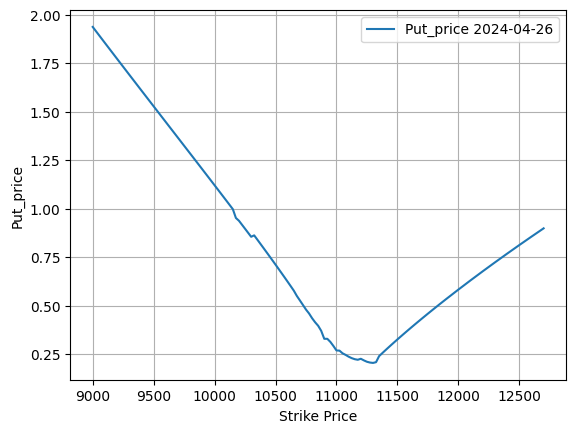

In [14]:
# Filtrando los datos por fecha y graficando
for fecha in fechas_unicas:
    # Filtra el DataFrame para la fecha actual en el bucle
    datos_fecha = combined_df.loc[fecha]
    
    # Grafica la columna Put_IV para la fecha seleccionada
    plt.figure()
    plt.plot(datos_fecha['Strike'], datos_fecha['Call_price'], linestyle='-', label=f'Put_price {fecha.date()}')
    plt.xlabel('Strike Price')
    plt.ylabel('Put_price')
    plt.legend()
    plt.grid(True)
    plt.show()
    break

In [15]:
fechas_unicas

DatetimeIndex(['2024-04-26', '2024-05-03', '2024-05-10', '2024-05-17',
               '2024-06-21', '2024-07-19', '2024-09-20', '2024-12-20',
               '2025-03-21', '2025-06-20', '2025-12-19'],
              dtype='datetime64[ns]', name='Fecha', freq=None)

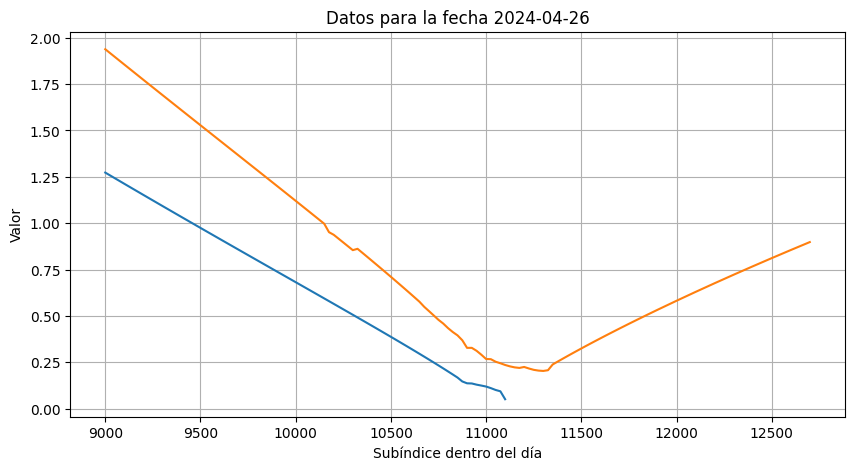

In [22]:
# Paso 1: Definir la fecha que quieres graficar
fecha_deseada = '2024-04-26'  # Cambia esta fecha según tus necesidades

# Paso 2: Filtrar los datos para la fecha seleccionada
datos_filtrados = combined_df.loc[fecha_deseada]

# Paso 3: Graficar los datos
plt.figure(figsize=(10, 5))  # Configura el tamaño del gráfico como desees
plt.plot(datos_filtrados['Strike'], datos_filtrados['Put_price'], linestyle='-')
plt.plot(datos_filtrados['Strike'], datos_filtrados['Call_price'], linestyle='-')
# Asegúrate de reemplazar 'tu_columna_de_datos' con el nombre de la columna real que deseas graficar

plt.title(f'Datos para la fecha {fecha_deseada}')
plt.xlabel('Subíndice dentro del día')  # Ajusta según la estructura de tu DataFrame
plt.ylabel('Valor')  # Ajusta este label según los datos que estás graficando
plt.grid(True)
plt.show()